 <center><font size="8">Model Evaluation</font></center>

In [1]:
# Import libraries
import copy
from tqdm.notebook import tqdm
import pprint
from ipywidgets import interact, GridspecLayout, interactive, interact_manual,Layout
import ipywidgets as widgets
from IPython.display import display
import torch
from src.constants import DATA_PATH, MASTER_THESIS_DIR, TRAINING_CONFIG_PATH, SAVED_MODELS_BASE_PATH,SUPERVISED_CONFIG_PATH
import pandas as pd
from src.data_loader.data_set import Data_Set
from src.experiments.evaluation_utils import calc_procrustes_transform
from src.utils import get_console_logger, read_json
from src.visualization.visualize import plot_hand
from torch.utils.data import DataLoader
from torchvision import transforms
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
from src.data_loader.utils import convert_2_5D_to_3D, convert_to_2_5D
from src.experiments.evaluation_utils import calculate_epe_statistics, evaluate,get_predictions_and_ground_truth, cal_auc_joints, get_pck_curves, get_procrustes_statistics
from src.data_loader.utils import get_train_val_split, get_data
from src.models.semisupervised.supervised_head_model import SupervisedHead
from IPython.display import clear_output
from src.experiments.utils import restore_model
import numpy as np
from src.models.supervised.denoised_baseline import DenoisedBaselineModel

In [2]:
# global variables:
results = None
model = None
x=y=None
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w",
         "text.color":"w"}
plt.rcParams.update(params)
mean, std = torch.tensor((0.485, 0.456, 0.406)), torch.tensor((0.229, 0.224, 0.225))
inv_normalize = transforms.Normalize(mean=-mean / std, std=1 / std)

In [3]:
# Load configuration
model_config = edict(read_json(SUPERVISED_CONFIG_PATH))
joints_mapping = {
    v: k
    for k, v in read_json(f"{MASTER_THESIS_DIR}/src/data_loader/joint_mapping.json")[
        "ait"
    ].items()
}
train_param = edict(
    read_json(f"{MASTER_THESIS_DIR}/src/experiments/config/training_config.json")
)
train_data = None


@interact(
    source=widgets.Dropdown(
        options=["interhand", "freihand", "youtube", "mpii"],
        value="freihand",
        description="source",
        disabled=False,
    )
)
def select_data(source):
    global train_data
    train_data = Data_Set(
        config=train_param,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            ]
        ),
        split="test",
        experiment_type="supervised",
        source=source,
    )

interactive(children=(Dropdown(description='source', index=1, options=('interhand', 'freihand', 'youtube', 'mp…

In [4]:
def select_augmentations(idx,random_crop,crop,color_jitter,cut_out, resize, color_drop,gaussian_blur,rotate,sobel_filter,gaussian_noise, training):
    global train_data
    train_param.augmentation_flags.random_crop = random_crop
    train_param.augmentation_flags.crop = crop
    train_param.augmentation_flags.color_jitter = color_jitter
    train_param.augmentation_flags.cut_out = cut_out
    train_param.augmentation_flags.resize = resize
    train_param.augmentation_flags.color_drop = color_drop
    train_param.augmentation_flags.gaussian_blur = gaussian_blur
    train_param.augmentation_flags.rotate = rotate
    train_param.augmentation_flags.sobel_filter = sobel_filter
    train_param.augmentation_flags.gaussian_noise = gaussian_noise
    train_data.augmenter = train_data.get_sample_augmenter(
        train_param.augmentation_params, train_param.augmentation_flags
    )
#     train_data.is_training(training)
    sample = train_data[idx]
    joints = sample["joints"]
    img = torch.flip(inv_normalize(sample["image"]),(0,))
#     print(img)
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)
    plt.imshow(transforms.ToPILImage()(img))
    plt.xticks([])
    plt.yticks([])
    plt.title("Augmentated sample",fontsize=20)
    plot_hand(ax, joints)
    return ax

font_size =4
augmentation_updated_interact = interactive(select_augmentations,
    idx = widgets.IntSlider(min=1, max=3000, step=5, value=3),
    random_crop=widgets.Checkbox(value=False, description=f"<font size='{font_size}'>Random crop</font>"),
    crop=widgets.Checkbox(value=True, description=f"<font size='{font_size}'>Crop</font>"),
    color_jitter=widgets.Checkbox(value=False, description=f"<font size='{font_size}'>Color jitter</font>"),
    cut_out=widgets.Checkbox(value=False, description=f"<font size='{font_size}'>Cut out</font>"),
    resize=widgets.Checkbox(value=True, description=f"<font size='{font_size}'>Resize</font>"),
    color_drop=widgets.Checkbox(value=False, description=f"<font size='{font_size}'>Color drop</font>"),
    rotate=widgets.Checkbox(value=False, description=f"<font size='{font_size}'>Rotate</font>"),
    gaussian_blur=widgets.Checkbox(value=False, description=f"<font size='{font_size}'>Blur(gaussian)</font>"),
    gaussian_noise=widgets.Checkbox(value=False, description=f"<font size='{font_size}'>Noise(gaussian)</font>"),
    sobel_filter=widgets.Checkbox(value=False, description=f"<font size='{font_size}'>sobel_filter</font>"),
    training = widgets.Checkbox(value=False, description=f"<font size='{font_size}'>Train set</font>"),)
augmentation_checkboxes = augmentation_updated_interact.children[:-1]
augmentation_grid = GridspecLayout(6,4, height='400px')
for i in range(5):
    for j in range(2):
        augmentation_grid[i,j] = augmentation_checkboxes[i*2+j+1]
augmentation_grid[5,2:] = augmentation_updated_interact.children[0]
augmentation_grid[2,3] = augmentation_updated_interact.children[-2]
augmentation_grid[:5,2:3] = augmentation_updated_interact.children[-1]
# augmentation_grid[:5,3:].layout.height = 'auto'
augmentation_updated_interact.children[0].description = f"<font size='{font_size}'>Index</font>"

<font size="6">Select augmentations</font>

In [8]:
display(augmentation_grid)

GridspecLayout(children=(Checkbox(value=False, description="<font size='4'>Random crop</font>", layout=Layout(…

<font size="6">Load Model</font>

In [5]:
from src.models.supervised.denoised_heatmap_model import DenoisedHeatmapmodel
def load_model(key, heatmap, checkpoint, resnet_size):
    global model
    print(f"Loading latest checkpoint of {key}")
    if checkpoint is None or checkpoint =="":
        checkpoint=""
    else:
        checkpoint=f"epoch={checkpoint}.ckpt"
    try:
        model_config.saved_model_name = key
        model_config.checkpoint = checkpoint
        model_config.resnet_size = resnet_size
        model_config.encoder_trainable = True
        if heatmap:
            model = DenoisedHeatmapmodel(model_config)
        else:
            model = DenoisedBaselineModel(model_config)
        model = restore_model(model, key, checkpoint)
        model.eval()
        print("Model loaded successfully!")
    except Exception as e:
        print(e)
        model = None
        print(f"Experiment {key} not found !")


def calc_results():
    global x, y
    global results
    global model
    global train_data
    global prediction_dict
    val_data = train_data
    torch.manual_seed(0)
    if model is not None:
        clear_output(wait=True)
        print(
            f"Calculating results on validation set formed with seed {train_param.seed}"
        )
        prediction_dict = get_predictions_and_ground_truth(
            model, val_data, num_workers=8, batch_size=128
        )
        epe_2D = calculate_epe_statistics(
            prediction_dict["predictions"], prediction_dict["ground_truth"], dim=2
        )
        epe_3D = calculate_epe_statistics(
            prediction_dict["predictions_3d"], prediction_dict["ground_truth_3d"], dim=3
        )
        epe_3D_recreated = calculate_epe_statistics(
            prediction_dict["predictions_3d"],
            prediction_dict["ground_truth_recreated_3d"],
            dim=3,
        )
        epe_3D__gt_vs_3D_recreated = calculate_epe_statistics(
            prediction_dict["ground_truth_3d"],
            prediction_dict["ground_truth_recreated_3d"],
            dim=3,
        )
        procrustes_result = get_procrustes_statistics(prediction_dict)
        if hasattr(model, "denoiser"):
            epe_3D_gt_vs_denoised = calculate_epe_statistics(
                prediction_dict["ground_truth_3d"],
                prediction_dict["predictions_3d_denoised"],
                dim=3,
            )
            auc_denoised = np.mean(cal_auc_joints(epe_3D_gt_vs_denoised["eucledian_dist"]))
            denoised_results = {
            "Mean_EPE_3D_denoised": epe_3D_gt_vs_denoised["mean"].cpu(),
            "Median_EPE_3D_denoised": epe_3D_gt_vs_denoised["median"].cpu(),
            "auc_denoised": auc_denoised,
        }
        else:
            denoised_results ={}
        eucledian_dist = epe_3D["eucledian_dist"]
        y, x = get_pck_curves(eucledian_dist, per_joint=True)
        auc = cal_auc_joints(eucledian_dist, per_joint=True)
        results = {**{
            "Mean_EPE_2D": epe_2D["mean"].cpu().numpy(),
            "Median_EPE_2D": epe_2D["median"].cpu().numpy(),
            "Mean_EPE_3D": epe_3D["mean"].cpu().numpy(),
            "Median_EPE_3D": epe_3D["median"].cpu().numpy(),
            "Mean_EPE_3D_R": epe_3D_recreated["mean"].cpu().numpy(),
            "Median_EPE_3D_R": epe_3D_recreated["median"].cpu().numpy(),
            "Mean_EPE_3D_R_v_3D": epe_3D__gt_vs_3D_recreated["mean"].cpu().numpy(),
            "Median_EPE_3D_R_V_3D": epe_3D__gt_vs_3D_recreated["median"].cpu().numpy(),
            "AUC": np.mean(auc),
        },**denoised_results, **procrustes_result}
        clear_output(wait=True)
        results_df = pd.DataFrame.from_dict(
            {k: ["{:.3f}".format(float(v))] for k, v in results.items()}
        ).T
        results_df = results_df.rename(columns={0: "value"})
        results_df.index.name = "Metric"
        results_df = results_df.reset_index()
#         del prediction_dict
        return display(results_df)
    else:
        return "No model selected!", "Nothing to plot in AUC"


def plot_results():
    global x, y
    global results
    if results is not None:
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(111)
        ax.set_facecolor("black")
        plt.plot(x, np.mean(y, axis=0), color="green", linewidth="1", alpha=1)
        plt.xlabel("error in mm", fontsize=12)
        plt.ylabel("Ratio of points below the error", fontsize=12)
        plt.legend(["Average PCK curve"], facecolor="black")
        plt.title(f"AUC: {results['AUC']}")
        return ax
    else:
        print("Calculate Results first!")


load_calculate_button_grid = GridspecLayout(3, 4, height="100px")
load_calculate_display_grid = GridspecLayout(5, 4, height="300px")
display(load_calculate_button_grid)
display(load_calculate_display_grid)

load_model_interact = interactive(
    load_model,
    {"manual": True},
    key=widgets.Text(
        value="76574ac3a17241dd856d173fb9ad7b1d",
        description=f"<font size='{font_size}'>Experiment</font>",
    ),
    heatmap=widgets.Checkbox(
        value=False, description=f"<font size='{font_size}'>Heatmap</font>"
    ),
    checkpoint=widgets.Text(
        value="",
        description=f"<font size='{font_size}'>Checkpoint</font>",
    ),
    resnet_size=widgets.Text(
        value="18",
        description=f"<font size='{font_size}'>Resnet size</font>",
    ),
    
)
plot_pck_interact = interactive(plot_results, {"manual": True})
calculate_result_interact = interactive(calc_results, {"manual": True})
experiment_key_textbox = load_model_interact.children[0]
load_model_button = load_model_interact.children[-2]
load_model_checkbox = load_model_interact.children[1]
load_model_button.description = "Load model"
plot_result_button = plot_pck_interact.children[0]
plot_result_button.description = "Plot pck curve"
calculate_result_interact.children[0].description = "Results"

load_calculate_button_grid[0, 0] = experiment_key_textbox
load_calculate_button_grid[1,0] = load_model_checkbox
load_calculate_button_grid[0, 1] = load_model_button
load_calculate_button_grid[2, 0] = load_model_interact.children[2]
load_calculate_button_grid[2, 1] = load_model_interact.children[3]
load_calculate_button_grid[0, 2] = calculate_result_interact.children[0]
load_calculate_button_grid[0, 3] = plot_result_button
load_calculate_display_grid[0:, 0] = load_model_interact.children[-1]
load_calculate_display_grid[0:, 2:3] = calculate_result_interact.children[-1]
load_calculate_display_grid[0:, 3:] = plot_pck_interact.children[-1]
calculate_result_interact

GridspecLayout(layout=Layout(height='100px'))

GridspecLayout(layout=Layout(height='300px'))

interactive(children=(Button(description='Results', layout=Layout(grid_area='widget006'), style=ButtonStyle())…

<font size="6">Visualize results</font>

In [39]:

def visualize1(idx, plot_gt, plot_pred):
    global model, train_data
    if model is not None:
        model.to(torch.device("cpu"))
        model.eval()
        sample = train_data[idx]
        joints = sample["joints"]
        joints3d_gt = sample["joints_raw"]
#         print(joints3d_gt)
        img = sample["image"]
        img_input = img.view(([1] + list(img.shape)))
        prediction = model(img_input).view(21, 3).detach().numpy()
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111)
#         plt.imshow(transforms.ToPILImage()(torch.flip(inv_normalize(img), (0,))))
        plt.imshow(transforms.ToPILImage()(inv_normalize(img)))
        ax.set_facecolor("black")
        if plot_gt:
            plot_hand(ax, joints * train_data[idx]["joints_valid"])
        if plot_pred:
            plot_hand(ax, prediction,linewidth='5',ms=8,)
        plt.xticks([])
        plt.yticks([])
        plt.savefig(f"qual_contrastive_fh_{idx}.png")
#         ax = fig.add_subplot(122, projection="3d")
#         ax.set_facecolor("black")
#         prediction3d = convert_2_5D_to_3D(
#             torch.from_numpy(prediction).clone(),
#             sample["scale"],
#             sample["K"],
#         )
#         error = (prediction3d - joints3d_gt.view(21, 3)).abs().mean()
#         if plot_gt:
#             plot_hand(ax, joints3d_gt* train_data[idx]["joints_valid"], plot_3d=True, alpha=0.2, linewidth="5")
#         if plot_pred:
#             plot_hand(ax, prediction3d, plot_3d=True, alpha=1, linestyle=":",linewidth='5',ms=2)
#         ax.set_title(f"3D joints from predictions  {error:.2f}")
        return ax
    else:
        print("Model is not defined!")


visualize_predictions = interactive(
    visualize1,
    idx=widgets.IntSlider(min=0,max=2000,step=10,value=1414),
    plot_gt=widgets.Checkbox(
        value=True, description=f"<font size='{font_size}'>Ground truth</font>"
    ),
    plot_pred=widgets.Checkbox(
        value=True, description=f"<font size='{font_size}'>Prediction</font>"
    ),
)
visualize_grid = GridspecLayout(5, 3, height="400px")
visualize_grid[1, 0] = visualize_predictions.children[2]
visualize_grid[2, 0] = visualize_predictions.children[1]
visualize_grid[:4, 1:] = visualize_predictions.children[-1]
visualize_grid[4, 1] = visualize_predictions.children[0]
visualize_predictions.children[0].description = f"<font size='{font_size}'>Index</font>"
visualize_grid

GridspecLayout(children=(Checkbox(value=True, description="<font size='4'>Prediction</font>", layout=Layout(gr…

In [20]:
train_data.source

'freihand'

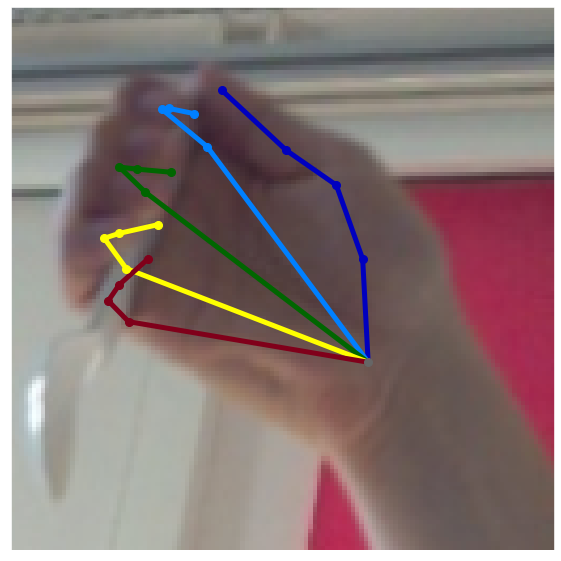

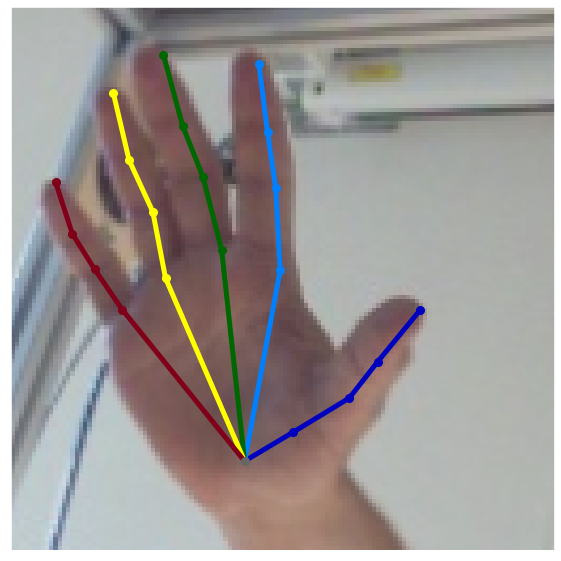

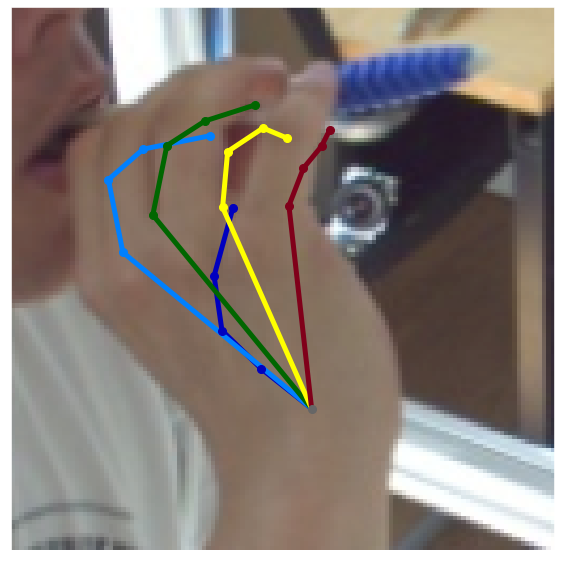

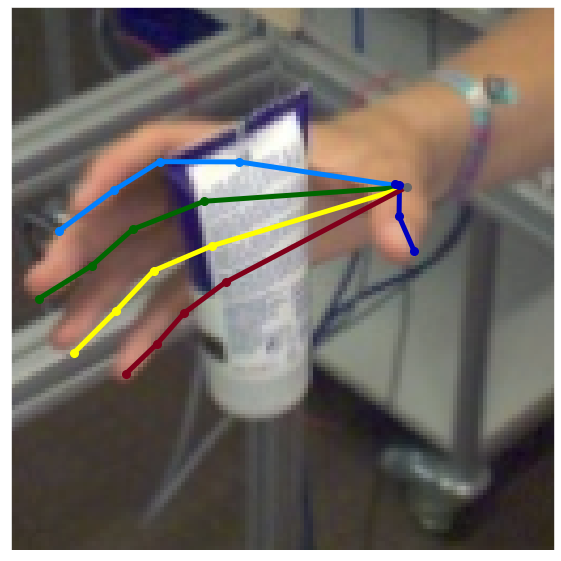

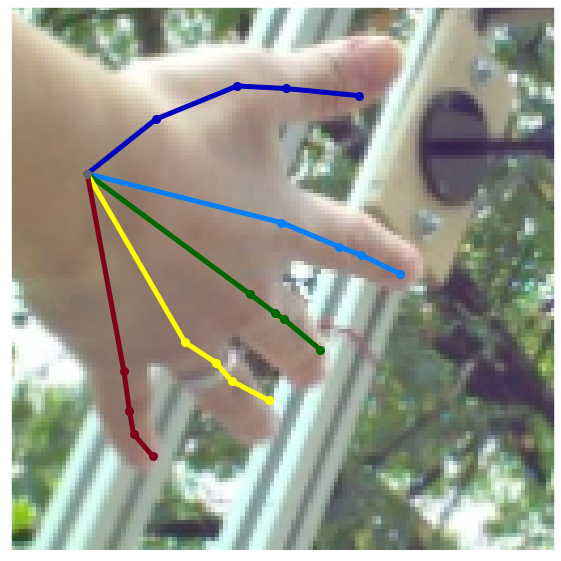

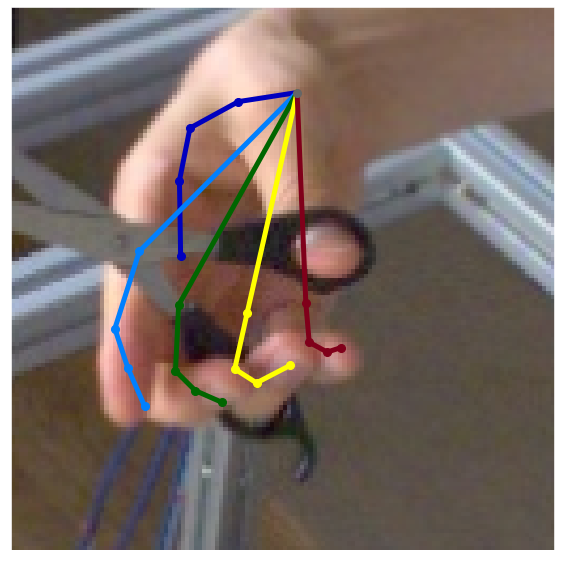

In [40]:
for idx in [500,1000, 1400,1410,1411, 1414]:
    visualize1(idx,False , True)